#Working with Yelp Review Text using NLTK

In [4]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
## Read in review data
## To get the full dataset, use the below: 
rvws = pd.read_csv("data\yelp_academic_dataset_review.csv")

## Below csv was created previously using the first 5,000 reviews. Once this is a working model we can expand it to a fuller dataset.
# reviews = pd.read_csv("data\yelp_academic_dataset_review.csv")
# rvws = reviews.iloc[:5000,:]
# rvws.to_csv("yelp_dataset_5k_review.csv")
#rvws = pd.read_csv("data\yelp_dataset_5k_review.csv")

In [73]:
## To make things easier when trying to analyze the text, let's just look at restaurants. For that, we'll have to join the review
## and business data. I'm also pulling the city and state so we can split this up by city, based on the assumption that
## language will vary depending on location.

headers = ['categories','business_id','city','state']
business = pd.read_csv("data\yelp_academic_dataset_business.csv", usecols = headers)
reviews_full = pd.merge(rvws, business, on = 'business_id')

In [74]:
## Now that we have the data joined with the business information, we can narrow the dataset to just restaurants so that
## the language we are looking for is more consistent. 
## (e.g. a good doctor review will have differnt language than a good restaurant review)

cat = reviews_full['categories']
rest = []

for x in range(len(cat)):
    if "Restaurants" in cat[x]:
        rest.append(1)
    elif "Food" in cat[x]:
        rest.append(1)
    else:
        rest.append(0)

reviews_full['restaurant'] = rest

## This will modify our reviews DataFrame to only include business that fall into the "restaurants" category,
## Then reset the index.

reviews_full = reviews_full[reviews_full['restaurant'] == 1]
reviews_full = reviews_full.reset_index(drop=True)

In [75]:
## In addition to narrowing it down to one city to work with. We will revisit the impact of location after doing as much
## as we can with just the text for all reviews in one city.

city = reviews_full['city']
city.value_counts()[:30]

Las Vegas          402889
Phoenix            156592
Scottsdale          85399
Charlotte           67038
Pittsburgh          50538
Tempe               47012
Henderson           32641
Chandler            30578
Madison             29697
Mesa                27842
Montréal            23631
Gilbert             19281
Glendale            16960
Edinburgh           13999
Montreal            12746
Peoria               8209
Champaign            6772
North Las Vegas      6458
Surprise             5283
Goodyear             4891
Avondale             3560
Queen Creek          3042
Cave Creek           2994
Urbana               2826
Matthews             2587
Middleton            1978
Karlsruhe            1710
Fort Mill            1656
Waterloo             1480
Concord              1333
dtype: int64

In [76]:
reviews = reviews_full[reviews_full['city'] == 'Avondale']
reviews = reviews.reset_index(drop=True)
reviews.head()

,user_id,review_id,text,votes.cool,business_id,votes.funny,stars,date,type,votes.useful,categories,state,city,restaurant
0,V0y4fqp-4pSRfsz0FmsjPA,r9Ow00PF8y7fv32Xtg4Gzg,So....You say you want authentico?? My family ...,8,cvhsdSDaWPjLVnTThQkx8g,7,5,2008-04-23,review,12,"[u'Mexican', u'Restaurants']",AZ,Glendale,1
1,L87hrFVD-53NV8xRvoWfUw,DagBfm4lxPUYqQ78haUJ9Q,I'm giving El Conquistador 4 stars for the foo...,0,cvhsdSDaWPjLVnTThQkx8g,0,3,2008-12-14,review,1,"[u'Mexican', u'Restaurants']",AZ,Glendale,1
2,Ogwv5L0BkHxxojLQc_ENIg,lf_nd6GVq_Rx19hLZENNOw,My husband and I moved to Phoenix from San Die...,0,cvhsdSDaWPjLVnTThQkx8g,0,5,2009-04-06,review,2,"[u'Mexican', u'Restaurants']",AZ,Glendale,1
3,gMU7u0IvLF8xF8zDPS7lvg,59o6fNgnwmC5_hhQDX5XgA,"In a nutshell: the food is delicious, the own...",0,cvhsdSDaWPjLVnTThQkx8g,0,4,2009-05-10,review,0,"[u'Mexican', u'Restaurants']",AZ,Glendale,1
4,VBw-kUZsxbIMwDGHJ7dl1w,JG81y1xgwJLPMIPBm33ZFA,El Conquistador is the best Mexican restaurant...,0,cvhsdSDaWPjLVnTThQkx8g,0,5,2009-08-14,review,0,"[u'Mexican', u'Restaurants']",AZ,Glendale,1


Value counts for each star so we can get a general sense of distribution:
5    5604
4    4995
3    2548
1    2053
2    1760
dtype: int64


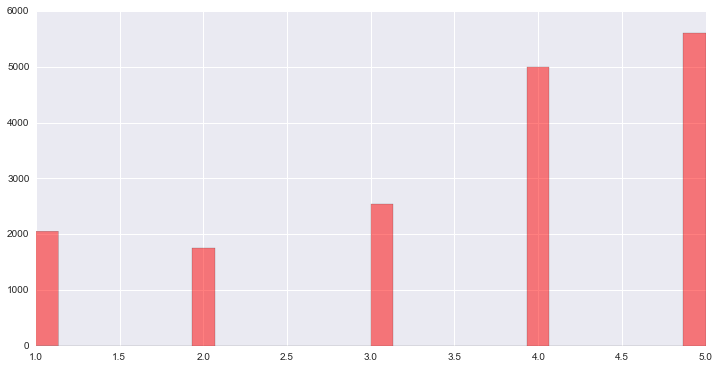

In [77]:
text = reviews['text']
stars = reviews['stars']

print "Value counts for each star so we can get a general sense of distribution:"
print stars.value_counts()
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
stars.hist(color='red', alpha=0.5, bins = 30)

In [78]:
## Let's create some data based on the text so we can run some regressions on characteristics of the text.

text_length = []
for x in range(len(reviews['text'])):
    text_length.append(len(text[x]))

reviews['text_length'] = text_length
reviews.head()

,user_id,review_id,text,votes.cool,business_id,votes.funny,stars,date,type,votes.useful,categories,state,city,restaurant,text_length
0,V0y4fqp-4pSRfsz0FmsjPA,r9Ow00PF8y7fv32Xtg4Gzg,So....You say you want authentico?? My family ...,8,cvhsdSDaWPjLVnTThQkx8g,7,5,2008-04-23,review,12,"[u'Mexican', u'Restaurants']",AZ,Glendale,1,1009
1,L87hrFVD-53NV8xRvoWfUw,DagBfm4lxPUYqQ78haUJ9Q,I'm giving El Conquistador 4 stars for the foo...,0,cvhsdSDaWPjLVnTThQkx8g,0,3,2008-12-14,review,1,"[u'Mexican', u'Restaurants']",AZ,Glendale,1,1292
2,Ogwv5L0BkHxxojLQc_ENIg,lf_nd6GVq_Rx19hLZENNOw,My husband and I moved to Phoenix from San Die...,0,cvhsdSDaWPjLVnTThQkx8g,0,5,2009-04-06,review,2,"[u'Mexican', u'Restaurants']",AZ,Glendale,1,552
3,gMU7u0IvLF8xF8zDPS7lvg,59o6fNgnwmC5_hhQDX5XgA,"In a nutshell: the food is delicious, the own...",0,cvhsdSDaWPjLVnTThQkx8g,0,4,2009-05-10,review,0,"[u'Mexican', u'Restaurants']",AZ,Glendale,1,498
4,VBw-kUZsxbIMwDGHJ7dl1w,JG81y1xgwJLPMIPBm33ZFA,El Conquistador is the best Mexican restaurant...,0,cvhsdSDaWPjLVnTThQkx8g,0,5,2009-08-14,review,0,"[u'Mexican', u'Restaurants']",AZ,Glendale,1,564


In [42]:
## Downloads from here: http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html
## Grab a generic words of positive and negative words; we are going to use these to get a sentiment score out of the text.

positives = open('data/positive-words.txt').read()
negatives = open('data/negative-words.txt').read()
pos_word_list = positives.split('\n')
neg_word_list = negatives.split('\n')

In [43]:
## Create function to output list of words in given list from a sentence.
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def review_to_wordlist(review, remove_stopwords=False):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.

    review_text = review   
    
    # 1. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)

    # 2. Convert words to lower case and split them
    words = review_text.lower().split()

    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    # 5. Return a list of words
    return(words)

def word_count(sentence, word_list):
    count = 0
    for x in review_to_wordlist(sentence):
        if x in word_list:
            count += 1
    
    return count

In [10]:
## In an initial run of this test, two separate values were created, which counted the positive and negative words in the corpus.
## Upon further review, this was deleted and replace with a sentiment score which was 1 for all positive words
## and -1 for all negative words

#pos_word_count = []
#neg_word_count = []
#pos_neg_ratio = []
#for x in text:
#    positive = word_count(x, pos_word_list)
#    negative = word_count(x, neg_word_list)
#    if (negative > 0):
#        ratio = float(positive)/negative
#    else:
#        ratio = positive
#    
#    if ((positive + negative) == 0):
#        sent = 0
#    else:
#        sent = ((positive-negative)/(float(positive)+negative))
#        
#    pos_word_count.append(positive)
#    neg_word_count.append(negative)
#    pos_neg_ratio.append(ratio)

#reviews['pos_word_count'] = pos_word_count
#reviews['neg_word_count'] = neg_word_count
#reviews['sentiment'] = sentiment
#reviews['pos_neg_ratio'] = pos_neg_ratio

In [44]:
%%time

## Use positive and negative words to give each piece of a text a sentiment score. The sentiment score ranges from
## -1 (all negative words) to 1 (all positive words).

sentiment = []
pos_neg_ratio = []
count = 0

for x in text:
    positive = word_count(x, pos_word_list)
    negative = word_count(x, neg_word_list)
    if (negative > 0):
        ratio = float(positive)/negative
    else:
        ratio = positive
    
    if ((positive + negative) == 0):
        sent = 1
    else:
        sent = ((positive-negative)/(float(positive)+negative))+1
        
    sentiment.append(sent)
    pos_neg_ratio.append(ratio)
    if count % 1000 == 0:
        print "Scoring text #{}".format(count)
    count += 1

reviews['sentiment'] = sentiment
reviews['pos_neg_ratio'] = pos_neg_ratio

Scoring text #0
Scoring text #1000
Scoring text #2000
Scoring text #3000
Scoring text #4000
Scoring text #5000
Scoring text #6000
Scoring text #7000
Scoring text #8000
Scoring text #9000
Scoring text #10000
Scoring text #11000
Scoring text #12000
Scoring text #13000
Scoring text #14000
Scoring text #15000
Scoring text #16000
Wall time: 4min 22s


In [45]:
## Features used for initial pass: text length, ratio of positive to negative words, and sentiment.

feature_list = ['text_length', 'pos_neg_ratio', 'sentiment']
features = reviews[feature_list]
stars = reviews[['stars']]

In [46]:
## Test using Various models. Set up the train test split first, then fit various models and see how they perform.

from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score

In [47]:
## Fit various models

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

x_train, x_test, y_train, y_test = cross_validation.train_test_split(features, stars, test_size=0.3, random_state=12)
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()
mnbayes = MultinomialNB()
linearSVC = LinearSVC()

tree.fit(x_train, y_train)
forest.fit(x_train, y_train)
mnbayes.fit(x_train, y_train)
linearSVC.fit(x_train, y_train)

print "Decision Tree score: {}".format(tree.score(x_test, y_test))
print "Random Forest score: {}".format(forest.score(x_test, y_test))
print "Multinomial Naive Bayes score: {}".format(mnbayes.score(x_test, y_test))
print "Linear SVC Score: {}".format(linearSVC.score(x_test, y_test))

C:\Users\samchu\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\samchu\AppData\Local\Continuum\Anaconda\lib\site-packages\sklearn\utils\validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Decision Tree score: 0.313089622642
Random Forest score: 0.318199685535
Multinomial Naive Bayes score: 0.394261006289
Linear SVC Score: 0.302279874214


C:\Users\samchu\AppData\Local\Continuum\Anaconda\lib\site-packages\sklearn\utils\validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [48]:
## Before trying to move on to a new method, let's make this a binary predictor by
## separating reviews into "good" (4-5 stars) and "bad" (1-3 stars)

# Playing with different star thresholds for what we consider a "good" or "bad" review.
star_threshold = 4

reviews['good'] = (reviews['stars'] >= star_threshold)
good = reviews['good']
good = good.map({True: 1, False: 0})

In [49]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(features, good, test_size=0.3, random_state=12)
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()
mnbayes = MultinomialNB()
linearSVC = LinearSVC()

tree.fit(x_train, y_train)
forest.fit(x_train, y_train)
mnbayes.fit(x_train, y_train)
linearSVC.fit(x_train, y_train)

print "Decision Tree score: {}".format(tree.score(x_test, y_test))
print "Random Forest score: {}".format(forest.score(x_test, y_test))
print "Multinomial Naive Bayes score: {}".format(mnbayes.score(x_test, y_test))
print "Linear SVC Score: {} \n".format(linearSVC.score(x_test, y_test))

print "Decision Tree AUC: {}".format(cross_val_score(tree, features, good, cv=3, scoring='roc_auc').mean())
print "Random Forest AUC: {}".format(cross_val_score(forest, features, good, cv=3, scoring='roc_auc').mean())
print "Multinomial Naive Bayes AUC: {}".format(cross_val_score(mnbayes, features, good, cv=3, scoring='roc_auc').mean())
print "Linear SVC AUC: {}".format(cross_val_score(linearSVC, features, good, cv=3, scoring='roc_auc').mean())

Decision Tree score: 0.665290880503
Random Forest score: 0.689465408805
Multinomial Naive Bayes score: 0.731328616352
Linear SVC Score: 0.658215408805 

Decision Tree AUC: 0.666007720206
Random Forest AUC: 0.730189074515
Multinomial Naive Bayes AUC: 0.777821703267
Linear SVC AUC: 0.698933182595


##Let's manipulate the data a little more, then vectorize the text and fit it

In [68]:
# from nltk.corpus import stopwords
# stop_words = set(stopwords.words("english"))
# from nltk.stem.wordnet import WordNetLemmatizer
# le = WordNetLemmatizer()
# asdf = ['cat','cats','catting','about','pooping','poop','poops','a','pooper','be']
# for x in asdf:
#     print le.lemmatize(x)
# asdf = [le.lemmatize(z) for z in asdf if not z in stop_words]
# asdf

In [79]:
%%time

## Let's work with the text before vectorizing. We're going to get rid of stop words and non-letters.
## We're also going to run the text through a lemmatizer, which will help narrow down the feature set.
## This will take some time.

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

stop_words = set(stopwords.words("english"))
count = 0
text_clean = text
lemm = WordNetLemmatizer()

for x in range(len(text_clean)):
    count +=1
    if count % 1000 == 0:
        print "Cleaning text #{}...".format(count)
    w = text[x]
    w = re.sub("[^a-zA-Z]"," ", w)    # gets rid of non-letters and substitutes it with a space
    w = word_tokenize(w)    # Tokenizes the sentence, breaking it up into a list of words rather than one long string.
    w = [lemm.lemmatize(z) for z in w if not z in stop_words]    # deletes stop words from the text, or words that don't add any meaning
    text_clean[x] = w

text_clean = [' , '.join(z).strip() for z in text_clean]

Cleaning text #1000...
Cleaning text #2000...
Cleaning text #3000...
Cleaning text #4000...
Cleaning text #5000...
Cleaning text #6000...
Cleaning text #7000...
Cleaning text #8000...
Cleaning text #9000...
Cleaning text #10000...
Cleaning text #11000...
Cleaning text #12000...
Cleaning text #13000...
Cleaning text #14000...
Cleaning text #15000...
Cleaning text #16000...


C:\Users\samchu\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyboardInterrupt: 

In [148]:
%%time
## Vectorize the text with sklearn's CountVectorizer.

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(decode_error = 'ignore')
vect.fit(text_clean)
text_dtm = vect.transform(text_clean)
text_array = text_dtm.toarray()
text_df = pd.DataFrame(text_array, columns = vect.get_feature_names())

In [149]:
## Initial test by running the test on the vectorization of the text.

x_train, x_test, y_train, y_test = cross_validation.train_test_split(text_array, stars, test_size=0.3, random_state=12)
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()
mnbayes = MultinomialNB()

tree.fit(x_train, y_train)
forest.fit(x_train, y_train)
mnbayes.fit(x_train, y_train)
linearSVC.fit(x_train, y_train)

print "Decision Tree score: {}".format(tree.score(x_test, y_test))
print "Random Forest score: {}".format(forest.score(x_test, y_test))
print "Multinomial Naive Bayes score: {}".format(mnbayes.score(x_test, y_test))
print "Linear SVC Score: {} \n".format(linearSVC.score(x_test, y_test))

Decision Tree score: 0.363068688671
Random Forest score: 0.348795718109
Multinomial Naive Bayes score: 0.448706512043


Per the above results, this performed slightly better than the model generated with the sentiment score, positive/negative ratio and length of text. Multinomial Naive Bayes performed the best so far as well.

In [150]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(text_array, good, test_size=0.3, random_state=12)
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()
mnbayes = MultinomialNB()

tree.fit(x_train, y_train)
forest.fit(x_train, y_train)
mnbayes.fit(x_train, y_train)
linearSVC.fit(x_train, y_train)

print "Decision Tree score: {}".format(tree.score(x_test, y_test))
print "Random Forests score: {}".format(forest.score(x_test, y_test))
print "Multinomial Naive Bayes score: {} \n".format(mnbayes.score(x_test, y_test))
print "Linear SVC Score: {} \n".format(linearSVC.score(x_test, y_test))

print "Decision Tree AUC: {}".format(cross_val_score(tree, text_array, good, cv=3, scoring='roc_auc').mean())
print "Random Forests AUC: {}".format(cross_val_score(forest, text_array, good, cv=3, scoring='roc_auc').mean())
print "Multinomial Naive Bayes AUC: {}".format(cross_val_score(mnbayes, text_array, good, cv=3, scoring='roc_auc').mean())
print "Linear SVC AUC: {}".format(cross_val_score(linearSVC, text_array, good, cv=3, scoring='roc_auc').mean())

Decision Tree score: 0.693131132917
Random Forest score: 0.743086529884
Multinomial Naive Bayes score: 0.817127564674 

Decision Tree AUC: 0.674537784076
Random Forest AUC: 0.766679499683
Multinomial Naive Bayes AUC: 0.790659426578


### Using the vectorization of the words, we get a respectable AUC for MN Bayes when testing for good / bad reviews. Let's continue to try to improve this.